In [320]:
from __future__ import print_function, division, absolute_import

import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import safeopt

mpl.rcParams['figure.figsize'] = (20.0, 10.0)
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.markersize'] = 20

In [321]:
# Bounds on the inputs variable
bounds = [(-10., 10.)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 1000)




# Define the objective function
kernel = GPy.kern.RBF(input_dim=len(bounds), variance=2., lengthscale=1.0, ARD=True)

#set a static seed for reproducibility
np.random.seed(2)

#define an example function
fun = safeopt.sample_gp_function(kernel, bounds, 0.05 ** 2, 100)

#consider 2 initially safe points   
x0_agent1 = np.zeros((1, len(bounds)))
x0_agent2 = np.zeros((1, len(bounds))) + 3 #slightly different starting point

#shared safe point
x0 = np.zeros((1, len(bounds)))

#consider 2 noise variances
noise_var1 = 0.1 ** 2
noise_var2 = 0.1 ** 2






Define the propabilistic models. a gaussian process model of out objective function based on the initial safe point of agent1 and the same for agent2.

In [322]:
#define 2 kernels of the 2 agents

gp_agent1 = GPy.models.GPRegression(x0_agent1, fun(x0_agent1), kernel, noise_var=noise_var1)
gp_agent2 = GPy.models.GPRegression(x0_agent2, fun(x0_agent2), kernel, noise_var=noise_var2)



opt_agent1 = safeopt.SafeOpt(gp_agent1, parameter_set, 0.0,threshold=0.2,beta=3)
opt_agent2 = safeopt.SafeOpt(gp_agent2, parameter_set, 0.0,threshold=0.2,beta=3)

In [323]:
def single_plot(agent,x,y):

    #plot the GP
    agent.plot(1000)

    #plot the true function
    plt.plot(x, y(x,noise=False), color='C2', alpha=0.3)

def multi_plot(agent1,agent2,x,fun):
    #plot the GP
    agent1.plot(1000)
    plt.plot(x, fun(x,noise=False), color='C2', alpha=0.3)
    plt.title('Agent 1 with context of Agent 2')


    agent2.plot(1000)
    plt.plot(x, fun(x,noise=False), color='C2', alpha=0.3)
    plt.title('Agent 2 with context of Agent 1')
    

In [324]:
# #plot gp of agent 1
# single_plot(opt_agent2,parameter_set,fun)
# single_plot(opt_agent1,parameter_set,fun)

In [325]:
#multi_plot(opt_agent1,opt_agent2,parameter_set,fun)

Agent 1
Initial safe point: [[0.]]
Initial safe point: [[3.]]


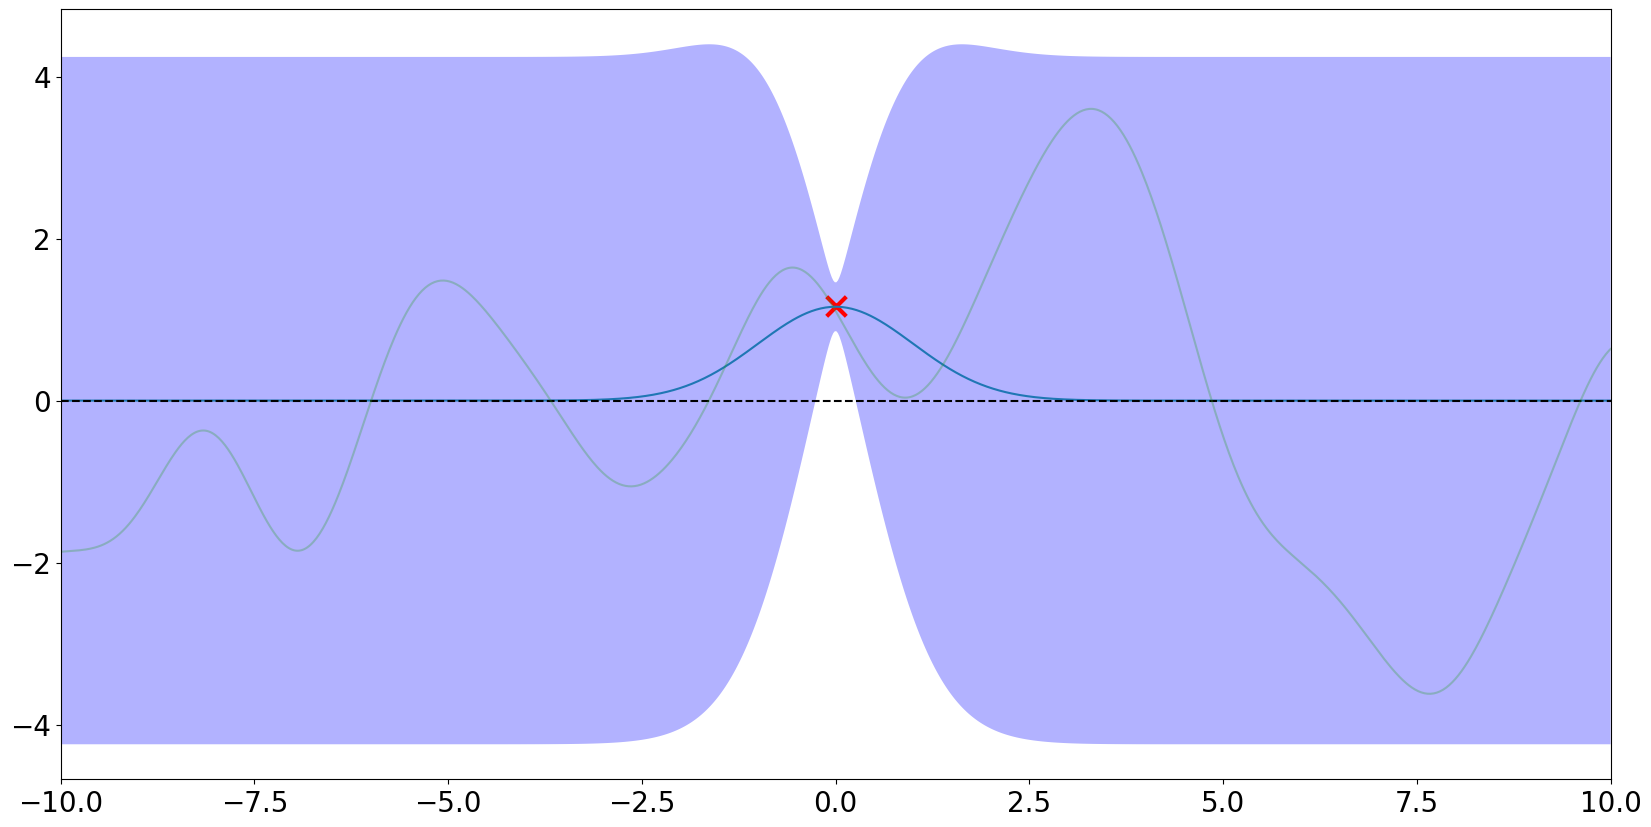

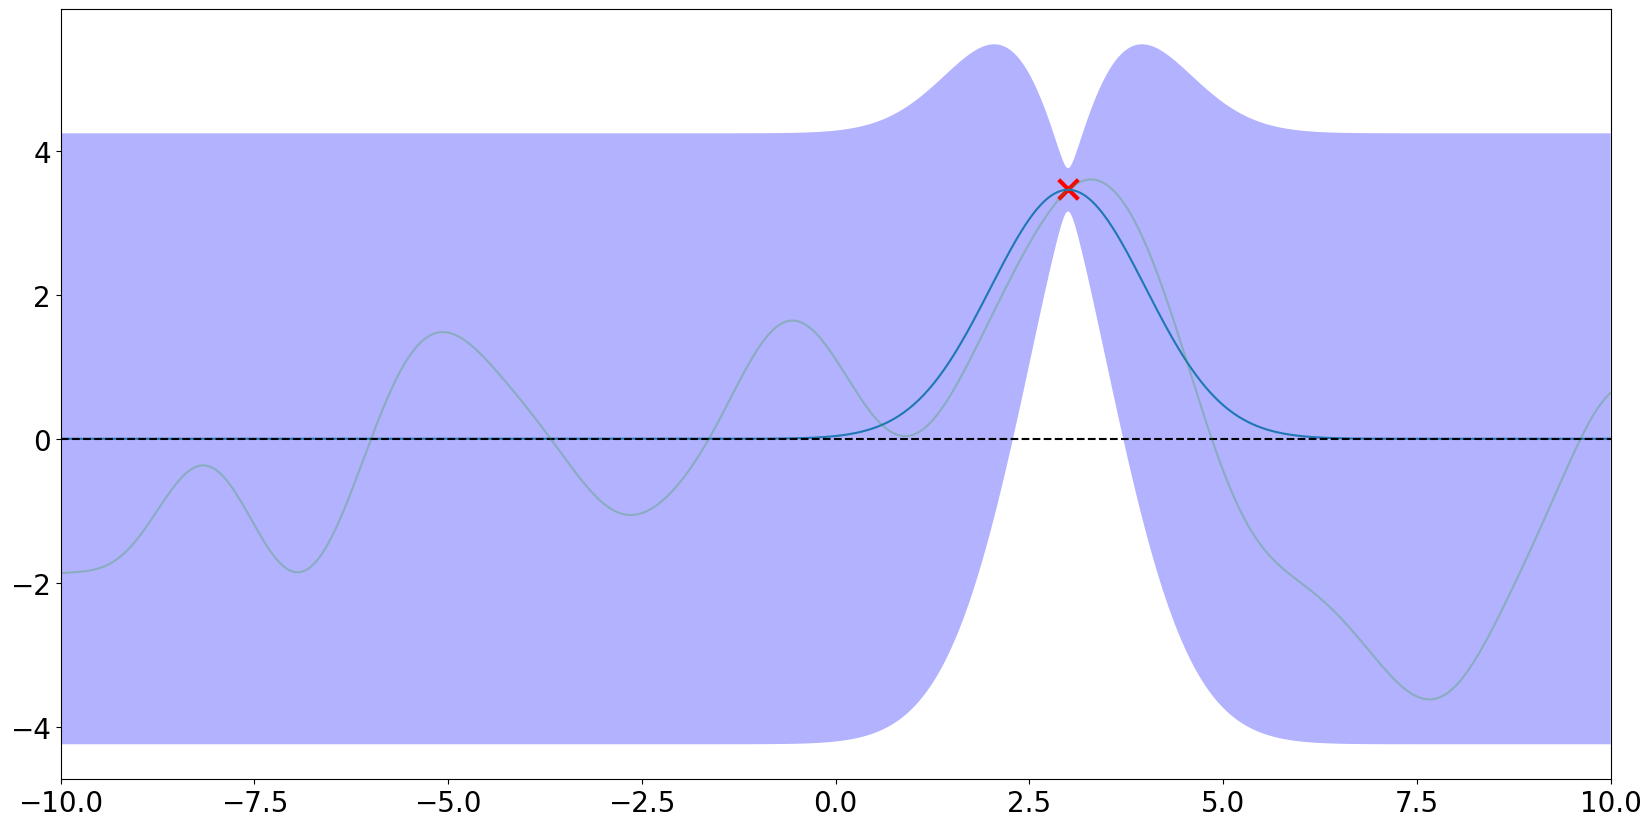

In [326]:
print('Agent 1')
print('Initial safe point:',x0_agent1)
print('Initial safe point:',x0_agent2)
single_plot(opt_agent1,parameter_set,fun)
single_plot(opt_agent2,parameter_set,fun)

Interactive Run of the algorithm

In [327]:
#agent 1 selects a point and gets a new sample suggestion
x_next1 = opt_agent1.optimize()
print('x_next1: ',x_next1)
#perfrom theoretical simulation
y1 = fun(x_next1)

print('y1: ', y1)

# #update the context of the guassian process of agent 1 by adding the new observation from the simulation
# opt_agent1.add_new_data_point(x_next1, y1)

#perfrom the same for agent 2

x_next2 = opt_agent2.optimize()
print('x_next2: ',x_next2)
y2 = fun(x_next2)
print('y2',y2)
# opt_agent2.add_new_data_point(x_next2, y2)

# #we can now exchange infromation between the 2 agents

x_next1:  [-0.25025025]
y1:  [[1.40445718]]
x_next2:  [2.29229229]
y2 [[2.32225648]]


Define Communication between the agents


In [328]:
def communicate(agent1,agent2,x_new1,y_new1,x_new2,y_new2):
    
    #agent 2 gets the context observed by agent 1
    agent2.add_new_data_point(x_new1, y_new1)

    #agent 1 gets the context observed by agent 2
    agent1.add_new_data_point(x_new2, y_new2)



Call the cummunicate function to exchange information between the agents

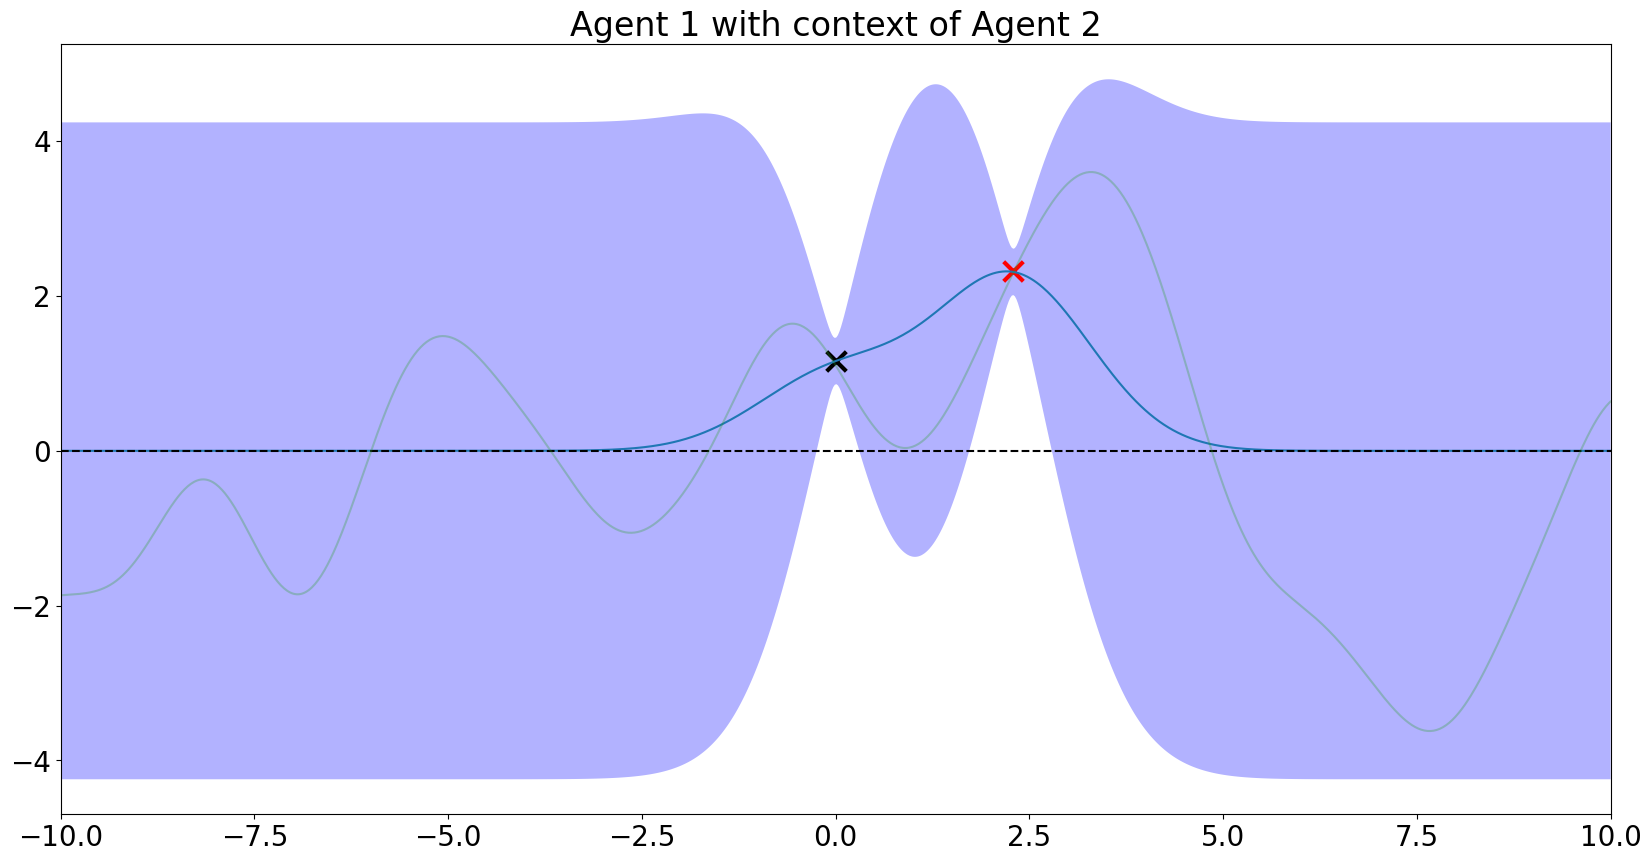

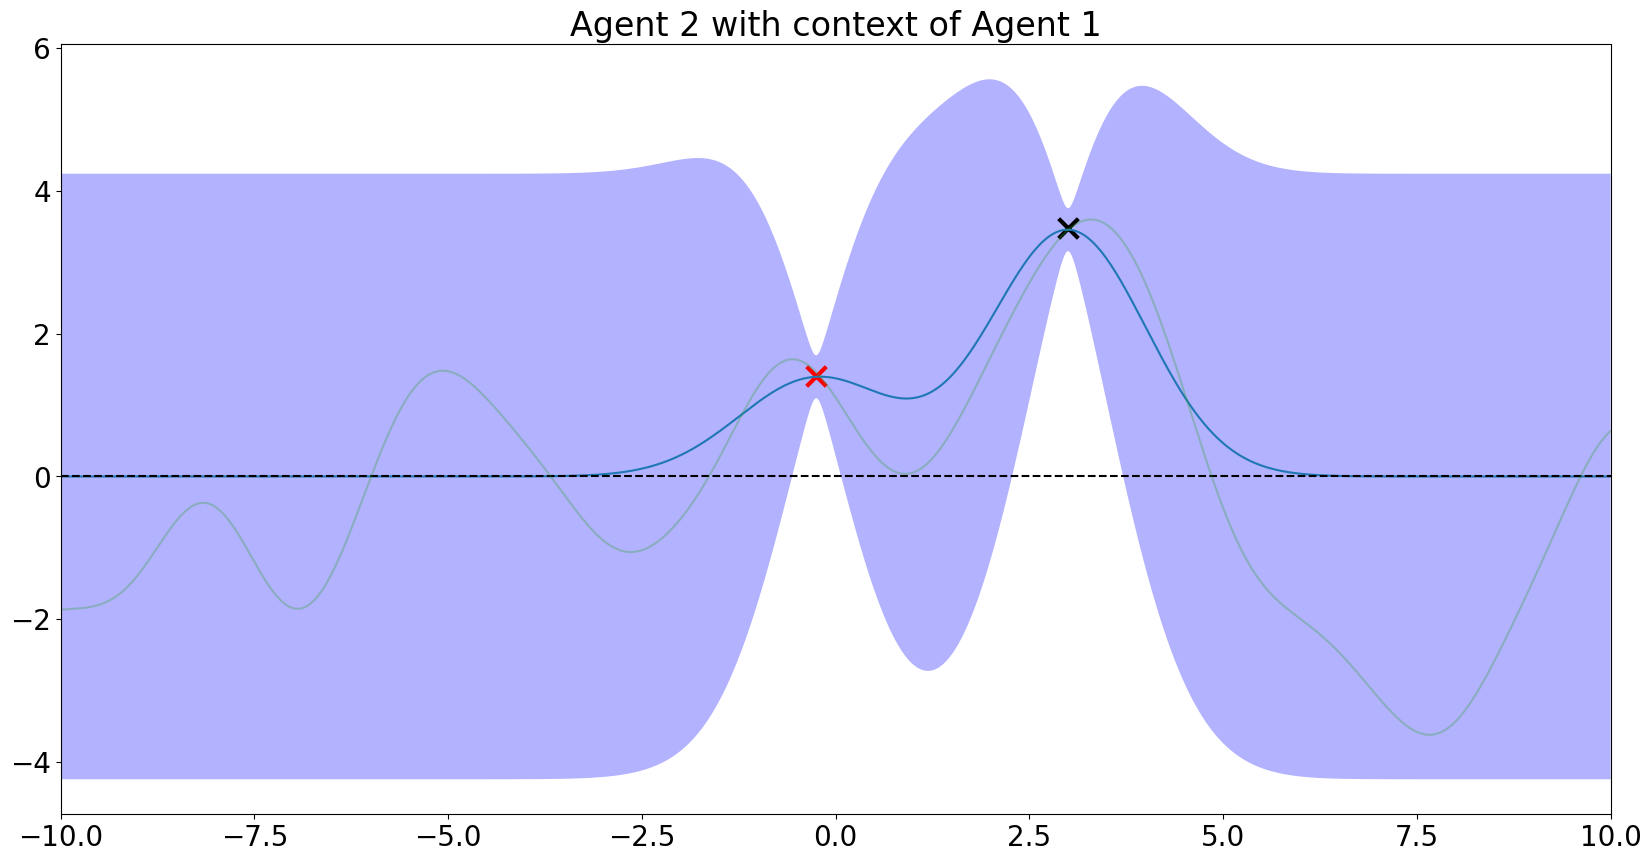

In [329]:
# #exchange information between the 2 agents
# communicate(opt_agent1,opt_agent2,x_next1,y1,x_next2,y2)

# #plot the new context of the 2 agents


# multi_plot(opt_agent1,opt_agent2,parameter_set,fun)


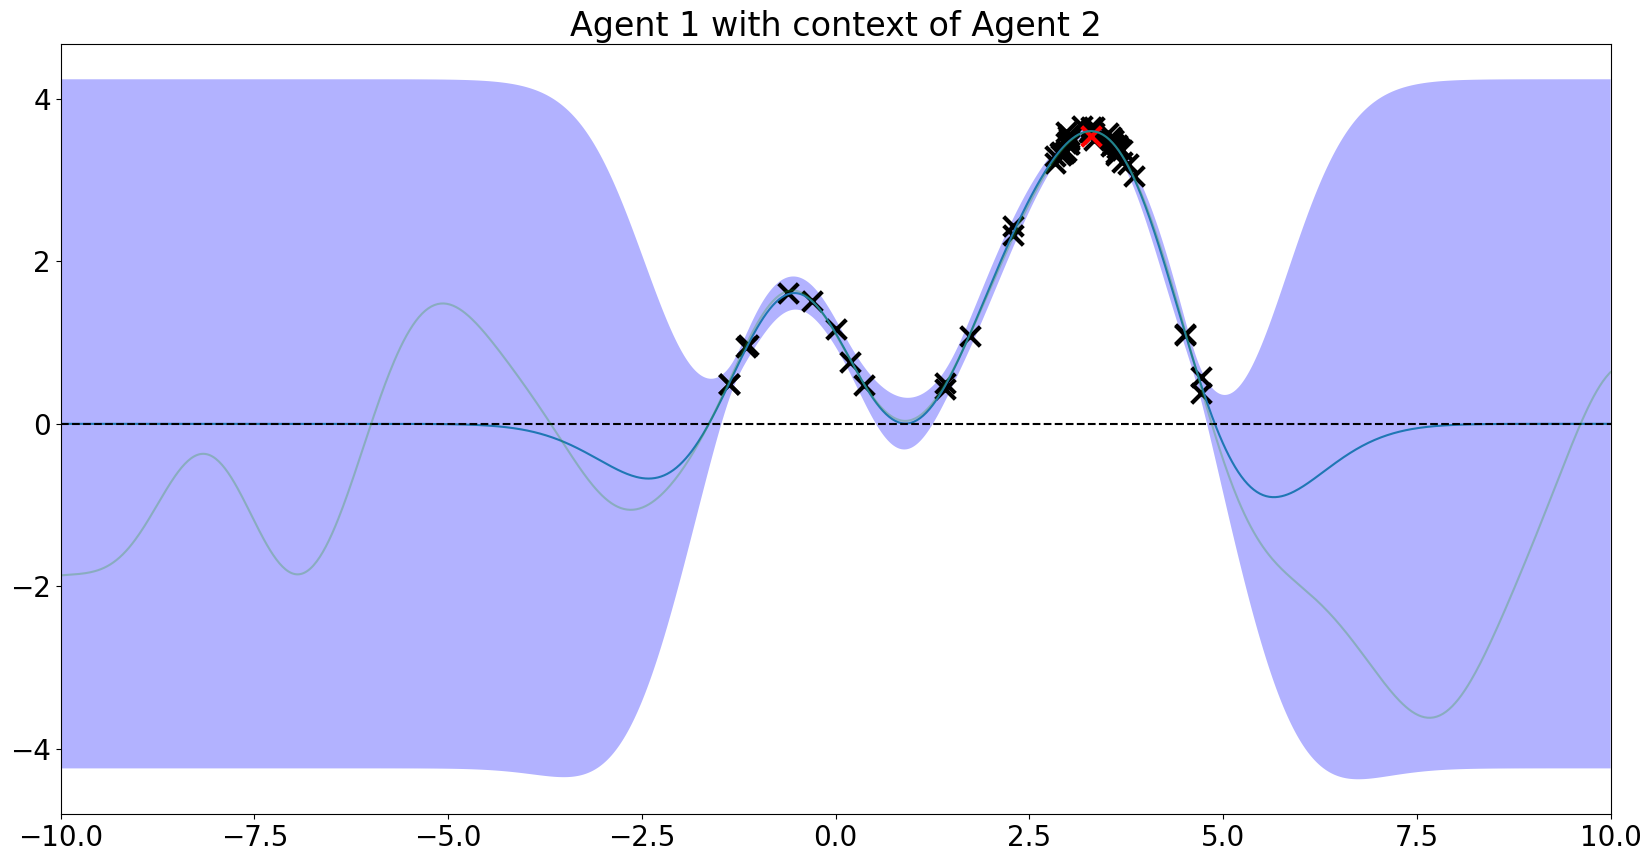

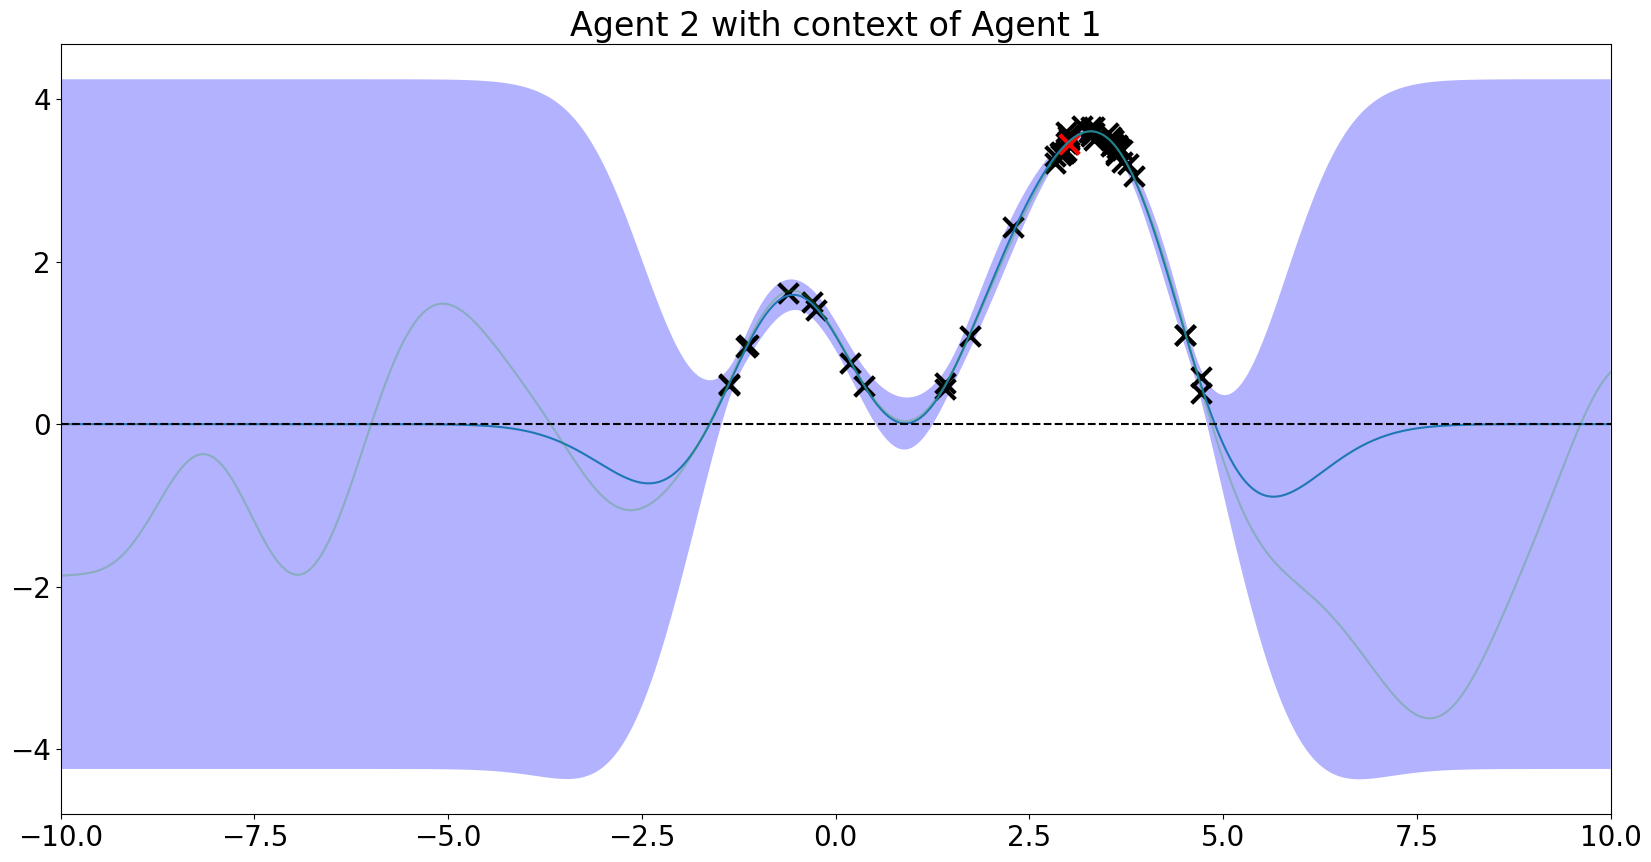

In [330]:
#loop through the process again

for t in range(30):
    #agent 1 selects a point and gets a new sample suggestion
    x_next1 = opt_agent1.optimize()
    y1 = fun(x_next1)
    #update the context of the guassian process of agent 1 by adding the new observation from the simulation
    opt_agent1.add_new_data_point(x_next1, y1)

    #perfrom the same for agent 2
    x_next2 = opt_agent2.optimize()
    y2 = fun(x_next2)
    opt_agent2.add_new_data_point(x_next2, y2)

    #exchange information between the 2 agents
    communicate(opt_agent1,opt_agent2,x_next1,y1,x_next2,y2)

    #plot the new context of the 2 agents
multi_plot(opt_agent1,opt_agent2,parameter_set,fun)